In [1]:
import pandas as pd
import numpy as np
from reV.SAM.generation import WindPower
import PySAM.Windpower as Windpower
import matplotlib.pyplot as plt
import json
import math
import os
import sqlite3
from rex import Resource
from reV.losses.power_curve import (
    PowerCurve,
    PowerCurveLossesInput,
    PowerCurveWindResource,
    adjust_power_curve,
)
from pyproj import Proj, Transformer
import ast
from timezonefinder import TimezoneFinder
import pytz
from datetime import datetime
import sqlite3

def flatten_sam_dict(nested_dict):
    flat = {}
    for group in nested_dict.values():
        flat.update(group)
    return flat

db_powercurves_path = r'C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\powercurves_table.csv'
db_powercurves = pd.read_csv(db_powercurves_path)

plant_data_path =r"C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\generators_table.csv"
windplant_database = pd.read_csv(plant_data_path)

db_turbine_path = r'C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\turbine_byplant_table.csv'
db_turbine = pd.read_csv(db_turbine_path)

data_folder = r"C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\HRRR_data\interpolated"
db_path = r"\\pnl\projects\Wind_Power_Data\Task 2\Task 2.1\Database\winddata_v11.db"   

turbine_updated_names = r"C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\turbines_Powercurve_mismatch.csv"
updated_names_df= pd.read_csv(turbine_updated_names, encoding="latin1")
plant_ids = [56394,56457]
#plant_ids = [56322,56270,56322,56457,56649,56774,57192,57050,57192,58441,56394,56644,56673,56773,57049,57188,57530]


In [ ]:
import pandas as pd


windplant_database_combos = windplant_database[['major_t_manu', 'major_t_model']].drop_duplicates()
windplant_database_combos= windplant_database_combos.rename(columns={'major_t_manu': 'manufacturer', 'major_t_model': 'model'})
db_powercurves_combos = db_powercurves[['manufacturer', 'model']].drop_duplicates()

def clean_text(s):
    return s.str.strip().str.lower()

#windplant_database_combos['manufacturer'] = clean_text(windplant_database_combos['manufacturer'])
#windplant_database_combos['model'] = clean_text(windplant_database_combos['model'])
#db_powercurves_combos['manufacturer'] = clean_text(db_powercurves_combos['manufacturer'])
#windplant_database_combos['model'] = clean_text(windplant_database_combos['model'])


df1_not_in_df2 = pd.merge(windplant_database_combos, db_powercurves_combos, on=['manufacturer','model'], how='left', indicator=True)
df1_not_in_df2 = df1_not_in_df2[df1_not_in_df2['_merge'] == 'left_only'][['manufacturer','model']]


df2_not_in_df1 = pd.merge(db_powercurves_combos, windplant_database_combos, on=['manufacturer','model'], how='left', indicator=True)
df2_not_in_df1 = df2_not_in_df1[df2_not_in_df1['_merge'] == 'left_only'][['manufacturer','model']]

print("Turbine in the windplant database but not in powercurves:")
print(df1_not_in_df2)

#df1_not_in_df2.to_csv("turbines_Powercurve_mismatch.csv", index=False)


Turbine in the windplant database but not in powercurves:
    manufacturer     model
0         Vestas   V39-500
1            EWT  DW54-900
2             GE   1.5 XLE
3         Vestas   V47-660
4         Vestas   V42-600
..           ...       ...
186       Vestas  V162-5.6
187           GE   3.4-140
188           GE   3.2-103
189       Vestas  V150-6.0
190           GE   5.5-158

[149 rows x 2 columns]


In [3]:
#Fixing turbine powercurve and mismatch

# Merge to align matches
merged = windplant_database.merge(
    updated_names_df,
    left_on=['major_t_manu', 'major_t_model'],
    right_on=['manufacturer', 'model'],
    how='left'
)

# Update only where we have a match AND no "Missing"
merged['major_t_manu'] = merged.apply(
    lambda r: r['new_manufacturer'] if pd.notna(r['new_manufacturer']) and r['new_manufacturer'] != 'Missing' else r['major_t_manu'],
    axis=1
)
merged['major_t_model'] = merged.apply(
    lambda r: r['new_model'] if pd.notna(r['new_model']) and r['new_model'] != 'Missing' else r['major_t_model'],
    axis=1
)

# Keep only original df1 columns (now updated)
windplant_database_updated = merged[windplant_database.columns]

print(windplant_database_updated)


      entity_id                        entity_name  plant_id  \
0         63560         Sand Point Generating, LLC         1   
1         63560         Sand Point Generating, LLC         1   
2         13642         Nome Joint Utility Systems        90   
3         13642         Nome Joint Utility Systems        90   
4         10633               City of Lamar - (CO)       508   
...         ...                                ...       ...   
1653      58842       Power Company of Wyoming LLC     58987   
1654      65708  Buffalo Branch Wind and Solar LLC     66701   
1655      65110                 Winding Stair Wind     65938   
1656      58842       Power Company of Wyoming LLC     58987   
1657      58842       Power Company of Wyoming LLC     58987   

                             plant_name plant_state          county  \
0                            Sand Point          AK  Aleutians East   
1                            Sand Point          AK  Aleutians East   
2                 

In [4]:
unique_sources = db_powercurves['source'].unique()
print(unique_sources)

['thewindpower.net' 'SAM' 'wind turbines db' 'Technology_Assumptions'
 'www.academia.edu']


In [3]:
db_path = r"\\pnl\projects\Wind_Power_Data\Task 2\Task 2.1\Database\winddata_v11.db"   # Windows

conn = sqlite3.connect(db_path)

# load table into dataframe
windplant_database = pd.read_sql_query("SELECT * FROM generators", conn)


powercurves = pd.read_sql_query("SELECT * FROM power_curve", conn)

db_powercurves = powercurves.groupby(['manufacturer','model','source']).agg({
    'wind_spd_ms': list,
    'power_kw': list,
}).reset_index()

turbines =pd.read_sql_query("SELECT * FROM turbines", conn)

db_turbines = turbines.groupby(['plant_id','turbine_model','project_name']).agg({
    'latitude': list,
    'longitude': list,
    'p_tnum':'first',
    'turbine_manufacturer':'first',
    'turbine_hub_height':'first',
    'turbine_rotor_diameter':'first',
    'turbine_total_height':'first',
    'power_diameter':'first'
}).reset_index()

conn.close()


In [3]:

# Check Verison of PySAM(recommended 6.0.1)
import PySAM
print(PySAM.__version__)

# Check Verison of reV(recommended 0.13.1)
import reV
print(reV.__version__)


6.0.1
0.13.1


In [5]:

tf = TimezoneFinder()

def get_utc_offset(lat, lon):
    """Return UTC offset string like 'UTC-7' from lat/lon"""
    tz_name = tf.timezone_at(lat=lat, lng=lon)
    if not tz_name:
        return None
    tz = pytz.timezone(tz_name)
    now = datetime.now(tz)
    offset_hours = now.utcoffset().total_seconds() / 3600
    return f"{offset_hours:+.0f}"

def filter_and_assign(df, value):
    """
    Return all rows where df['name'] == value.
    """
    filtered_df = df[df['plant_id'] == value].copy()

    # Add UTC offset column
    filtered_df["UTC_offset"] = filtered_df.apply(
        lambda row: get_utc_offset(row["latitude"], row["longitude"]), axis=1
    )
    filtered_df["elevation"] = 0 

    return filtered_df

def combine_lists(x):
    return sum(x, [])

Processing 56394
✅ Loading CSV: C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\HRRR_data\interpolated\56394_Forest_Creek_Wind_Farm_LLC.csv


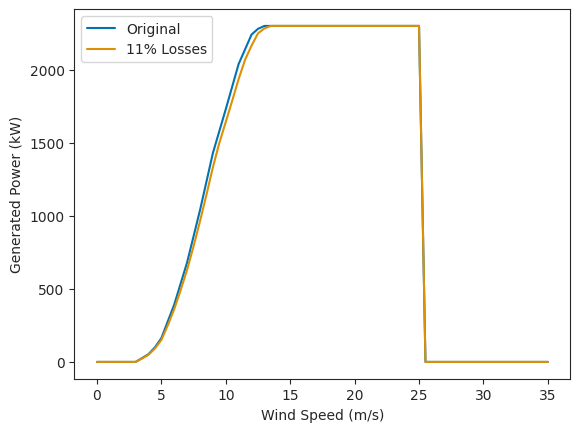

{'latitude': 32.039, 'longitude': -101.22, 'elevation': 0.0, 'year': 2018, 'fields': [1, 2, 3, 4], 'heights': [80, 80, 80, 80], 'data': [[-7.0519199999999955, 92940.49209007973, 6.8146706, 23.500286], [-7.319559999999967, 92989.01957632993, 6.680146, 25.876944], [-7.070619999999963, 93049.30089904682, 6.6519394, 29.646944], [-6.867599999999982, 93099.51903802413, 6.1848264, 27.595858], [-7.66116999999997, 93156.04832237246, 6.342592, 25.817024], [-7.86346999999995, 93185.00953513564, 6.6001544, 31.674946], [-8.171419999999955, 93213.58598594714, 7.0083203, 32.18553], [-8.355779999999982, 93252.50585919082, 6.7969522, 26.367687], [-8.681979999999953, 93290.90744621334, 7.422811, 26.873241], [-8.957679999999982, 93289.90136393138, 7.8615546, 26.21774], [-10.738069999999993, 93293.25012565014, 7.6519995, 29.816465], [-11.66807, 93309.586333701, 7.477938, 25.477917], [-12.251319999999964, 93337.09340824102, 6.998635, 24.117037], [-12.909670000000006, 93364.30649177327, 6.680866, 25.96725],

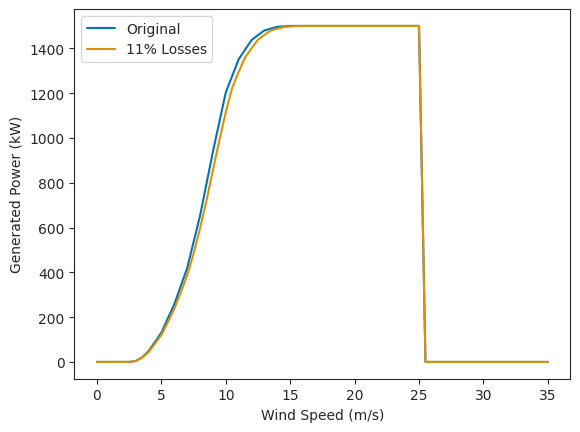

{'latitude': 32.92544, 'longitude': -101.2194, 'elevation': 0.0, 'year': 2018, 'fields': [1, 2, 3, 4], 'heights': [80, 80, 80, 80], 'data': [[-8.614419999999996, 93538.58405584726, 5.327893, 13.208239], [-8.632059999999967, 93607.80006982446, 3.5001807, 9.919918], [-8.570619999999963, 93667.40806255455, 3.1548967, 22.905188], [-9.055099999999982, 93725.01533618213, 3.4164848, 36.924805], [-9.34866999999997, 93753.62673297292, 4.1344256, 45.51599], [-9.30096999999995, 93803.28708153027, 5.494747, 44.345516], [-10.671419999999955, 93827.90322621432, 5.818093, 44.054554], [-11.980779999999982, 93872.48473439143, 5.82372, 32.67103], [-12.806979999999953, 93908.94954608926, 6.0532713, 26.149279], [-13.520179999999982, 93906.24144634744, 6.0453067, 27.437983], [-14.050569999999993, 93924.00802196791, 5.740419, 27.828186], [-14.23057, 93933.21425720754, 6.2756643, 27.566456], [-14.501319999999964, 93932.17633823141, 5.9958897, 29.853468], [-15.034670000000006, 93979.59876968309, 6.0954776, 28

In [ ]:
run_number = '4'
for plant_id in plant_ids:
    new_plant_df =filter_and_assign(windplant_database_updated, plant_id)
    group_col = "major_t_model"     # column to group by
    sum_cols = ["nameplate_capacity_mw","n_turbines"]       # numeric columns to sum

    #  Coerce numeric columns 
    for c in sum_cols:
        new_plant_df[c] = pd.to_numeric(
            new_plant_df[c].astype(str).str.replace(',', '').str.strip(),
            errors='coerce'
        ).fillna(0)

    #  Identify non-sum  columns 
    first_cols = [c for c in new_plant_df.columns if c not in sum_cols]

    # --- 3) Group by the turbine type within plant and combine capacity and number of turbines---
    combined_df = (
        new_plant_df.groupby(group_col, as_index=False)
            .agg({**{c: 'first' for c in first_cols}, **{c: 'sum' for c in sum_cols}})
    )

    for c in sum_cols:
        new_plant_df[c] = pd.to_numeric(
            new_plant_df[c].astype(str).str.replace(',', '').str.strip(),
            errors='coerce'
        ).fillna(0)


    # Have to specify within the turbine 
    row = db_turbine[db_turbine['plant_id'] == plant_id]

    #combined = (
        #df.groupby('group', sort=False)
        #.agg({
         #   'values': combine_lists,
         #   'other_info': 'first',
          #  'note': 'first'
        #})
        #.reset_index()
    #)

    number = str(plant_id)  # convert to string just in case
    print(f"Processing {number}")

    # Find all files in the folder that contain this number
    matching_files = [f for f in os.listdir(data_folder) if number in f and f.endswith(".csv")]

    if not matching_files:
        print(f"⚠️ No CSV found containing '{number}'")
        continue

    if len(matching_files) > 1:
        print(f"Multiple files found for '{number}': {matching_files}")
        # you can pick the first one or add logic to choose
        csv_file = matching_files[0]
    else:
        csv_file = matching_files[0]

    csv_path = os.path.join(data_folder, csv_file)
    print(f"✅ Loading CSV: {csv_path}")

    # Load timeseries CSV
    ts_df = pd.read_csv(csv_path)
    data_df = ts_df

    data_df['datetime'] = pd.to_datetime(data_df['valid_time'])
    data_df.set_index('datetime', inplace=True)

    # Lapse rate and height
    lapse_rate = 0.0065  # °C/m or K/m

    surface_pressure = data_df['pressure_Pa']  
    temperature = data_df['temperature_K'] 

    # change with height of turbine
    height_80 = 80
    height_140 = 140

    g = 9.80665
    R = 287.05

    #Find Pressure at 80m and 140m above surface level
    pressure_80m = surface_pressure * np.exp(-g * height_80 / (R * temperature))
    pressure_140m = surface_pressure * np.exp(-g * height_140 / (R * temperature))

    data_df['Pressure_80m'] = (pressure_80m) 
    data_df['Pressure_140m'] = pressure_140m
    data_df['temperature'] = data_df['temperature_K'] -273.15

    data_df['datetime'] = pd.to_datetime(data_df['valid_time'])
    data_df.set_index('datetime', inplace=True)

    data_df.rename(columns={'Pressure_80m': 'pressure', 'wind_speed': 'windspeed', 'wind_dir': 'winddirection'}, inplace=True)


    #iterate over turbine type
    for idx, row in combined_df.iterrows():
        single_df = pd.DataFrame([row])
        plant_capacity = single_df['nameplate_capacity_mw']*1000 # convert to kw
        
        #create meta data
        meta_df = pd.DataFrame()
        meta_df['latitude'] = single_df['latitude']
        meta_df['longitude'] = single_df['longitude']
        meta_df['elevation'] = single_df['elevation']
        meta_df['timezone'] = single_df['UTC_offset'].astype(int)
  
        # pull turbine locations(need to alter to be able to handle multiple sites)
        row = db_turbine[db_turbine['plant_id'] == plant_id]
        x_coords = ast.literal_eval(row['longitude'].iloc[0])
        y_coords = ast.literal_eval(row['latitude'].iloc[0])

        # Use transformer to change lat/long into (x,y) coordinates
        transformer = Transformer.from_crs("epsg:4326", "epsg:32611", always_xy=True)  # WGS84 to UTM zone 14N
        lon_list, lat_list = transformer.transform(x_coords, y_coords)

        # Shift so first turbine is at (0, 0)
        x_coords = np.array(lon_list) - lon_list[0]
        y_coords = np.array(lat_list) - lat_list[0]

        #collect turbine data
        turbine_model = single_df['major_t_model'].iloc[0]
        turbine_manufacturer = single_df['major_t_manu'].iloc[0]
        rotor_diameter = row['turbine_rotor_diameter'].iloc[0]
        hub_height = row['turbine_hub_height'].iloc[0]

        # have to add something to specify different powercurve sources
        #collect powercurve data
        model_row = db_powercurves[(db_powercurves['model'] ==turbine_model) & (db_powercurves['manufacturer'] == turbine_manufacturer) ] #&  (db_powercurves['source'] == 'thewindpower.net' )]
        wind_speed = model_row['wind_spd_ms'].iloc[0]
        power_out = model_row['power_kw'].iloc[0]

        temperatures = data_df['temperature'] 
        pressures = data_df['pressure']
        wind_speeds = data_df['windspeed']

        #power curve losses
        wind_speed = ast.literal_eval(wind_speed)
        power_out = ast.literal_eval(power_out)
        pc_wind_speed = pd.Series(wind_speed)
        pc_generation = pd.Series(power_out)

        # have to incorporate turbine powercurve scaling if using the generic power curve

        #rev_capacity = x_coords.size * pc_generation.iloc[-1]
        #power_curve_scaling_factor = plant_capacity.iloc[0]/rev_capacity
        #pc_generation_scaled = [x * power_curve_scaling_factor for x in pc_generation]

        power_curve_loss_info = {
            'target_losses_percent': 5,
            'transformation': 'exponential_stretching'
        }

        power_curve = PowerCurve(pc_wind_speed, pc_generation)
        resource_data = PowerCurveWindResource(temperatures, pressures, wind_speeds)
        target_losses = PowerCurveLossesInput(power_curve_loss_info)

        new_curve = adjust_power_curve(
            power_curve, resource_data, target_losses
        )
        _ = plt.plot(power_curve.wind_speed, power_curve, label='Original')
        _ = plt.plot(new_curve.wind_speed, new_curve.generation, label='11% Losses')
        _ = plt.legend(loc='upper left')
        _ = plt.xlabel("Wind Speed (m/s)")
        _ = plt.ylabel("Generated Power (kW)")
        _ = plt.show()


        windspeeds_list = new_curve.wind_speed.tolist()
        powerout_list = new_curve.generation.tolist()

        #create wind resource dictionary 
        ordered_fields = ['temperature', 'pressure','windspeed', 'winddirection']
        field_ids = [1, 2, 3, 4]
        heights = [80, 80, 80, 80]  # change to match hub height

        df_subset = data_df[ordered_fields].copy().dropna()
        data_array = df_subset[ordered_fields].values.tolist()

        wind_resource_dict = {
            'latitude':  float(meta_df['latitude'].iloc[0]),
            'longitude': float(meta_df['longitude'].iloc[0]),
            'elevation' : float(meta_df['elevation'].iloc[0]),
            'year': 2018,
            'fields': field_ids,
            'heights': heights,
            'data': data_array,
            'rh' : data_df['rh'].values.tolist()
        }
        print(wind_resource_dict)

        # create wind configuration with specified parameters
        wind_config = Windpower.new()
        wind_config.Turbine.wind_turbine_hub_ht = hub_height
        wind_config.Turbine.wind_turbine_rotor_diameter = rotor_diameter #97 A1
        wind_config.Resource.wind_resource_model_choice = 0 #hourly
        wind_config.Turbine.wind_turbine_powercurve_windspeeds = windspeeds_list
        wind_config.Turbine.wind_turbine_powercurve_powerout = powerout_list
        wind_config.Losses.turb_generic_loss =0
        wind_config.Losses.wake_int_loss = 0
        #icing stuff
        wind_config.Losses.en_icing_cutoff = 1
        wind_config.Losses.icing_cutoff_temp = -18
        wind_config.Losses.icing_cutoff_rh = 95
        wind_config.Losses.low_temp_cutoff = -29

        wind_config.Farm.wind_farm_wake_model = 1 #0-3 simple, park, ev,constant
        wind_config.Farm.system_capacity = plant_capacity.iloc[0]#Spring Valley
        wind_config.Farm.wind_resource_turbulence_coeff = 0.10 # remove
        wind_config.Farm.wind_farm_xCoordinates = x_coords
        wind_config.Farm.wind_farm_yCoordinates = y_coords
        wind_config.Farm.wake_loss_multiplier = 1.5 #value greater than means increased wake losses, value less than 1 means decreased wake losses, cannot be assigned for constant model
        wind_config.Resource.wind_resource_data = wind_resource_dict
        wind_config.Farm.park_wake_decay_constant = 0.075 #0.05-0.075
        wind_config.Turbine.wind_resource_shear = 0.15 #remove? # shouldnt effect anything because we have wind speed at hub height
        wind_config.execute()


        # Access PySAM results
        gen_profile_PySAM = wind_config.Outputs.gen
        capacity_factor_PySAM = tuple(x / plant_capacity  for x in gen_profile_PySAM)
        PySAM_CF = pd.DataFrame(capacity_factor_PySAM, columns=['Capacity Factor'])
        wind_speeds_PySAM = wind_config.Outputs.wind_speed
        print(capacity_factor_PySAM)


        # Run reV
        nested_dict = wind_config.export()
        flat_dict= flatten_sam_dict(nested_dict)
        with open("sam_inputs_flat.json", "w") as f:
            json.dump(flat_dict, f, indent=2)
            #Set Parameters
        output_request = ['gen_profile','capacity_factor','wind_speed', 'cf_profile']
        wind_simulation = WindPower(
            resource  = data_df[['windspeed', 'temperature', 'pressure','winddirection','rh']], 
            meta = meta_df,
            sam_sys_inputs = flat_dict,
            output_request = output_request
        )
        wind_simulation.run()
        outputs = wind_simulation.outputs
        wind_speed_reV_SAM_1 = outputs['wind_speed']
        gen_profile_reV_SAM_1 = outputs['gen_profile']
        cf_profile_reV_SAM_1 = outputs['cf_profile']
    

        df_combined_reV = pd.DataFrame({
            'datetime': data_df.index,
            'cf_reV': cf_profile_reV_SAM_1,
            'gen_reV' : gen_profile_reV_SAM_1,
            'gen_SAM' : gen_profile_PySAM
        })

        #Export Profiles to csv
        dire = f'./rev_HRRR_data/{plant_id}'
        os.makedirs(dire, exist_ok=True)
        safe_model = str(turbine_model).replace("/", "_").replace("\\", "_")
        save_path = (os.path.join(dire, f"{plant_id}_{safe_model}_{run_number}.csv")) 
        #df_combined_reV.to_csv(save_path, index=False)

In [142]:
# === Step 1: Define input files and capacities ===
file_farm1 = save_path = r"C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\reV_HRRR_data\NGW\NGW_1_5_scaled.csv"
file_farm2 = save_path = r"C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\reV_HRRR_data\NGW\NGW_2_5_scaled.csv"
save_path = r"C:\Users\mouc074\OneDrive - PNNL\Documents\wind_energy_research\wind_data\rev_HRRR_data\NGW\NGW_5_combined.csv"
capacity_farm1 = 106.5  # in MW
capacity_farm2 = 103.5  # in MW

# === Step 2: Read CSVs into DataFrames ===
df1 = pd.read_csv(file_farm1, parse_dates=['datetime'])
df2 = pd.read_csv(file_farm2, parse_dates=['datetime'])

# === Step 3: Merge on timestamp (inner join keeps aligned rows only) ===
df_combined_array = pd.merge(df1, df2, on='datetime', suffixes=('_f1', '_f2'))

# === Step 4: Compute combined capacity factor, weighted by each farm’s capacity ===
total_capacity = capacity_farm1 + capacity_farm2

df_combined_array['combined_cf'] = (
    df_combined_array['value_f1'] * capacity_farm1 +
    df_combined_array['value_f2'] * capacity_farm2
) / total_capacity



df_combined_array.to_csv(save_path, index=False)